# MNIST Handwritten Digit Recognition in PyTorch



## Introduction
I was reading through [FastAI's material](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) which covered the basics of a neural network while showing an example of MNIST character recognition. However it was a simple binary classifier which recognizes if a digit was 3 or 7. The complete classification was left as an open assignment. I tried looking up existing articles on MNIST character recognition and most of the articles dived right into Pytorch which was confusing for me.

So in this article,  I attempt to dissect the neural network character recognition process, trying to cover the basics, implementing it manually first and then later in Pytorch. It did take me some time to complete this article, but I do find myself looking back to this article to cover the basics.

## Environment Setup
Since we eventually want to code in Pytorch, I will start straight away by using torch instead of numpy so we can switch between manual methods and later replace them with standard Pytorch functions.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 112.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.0 MB/s eta 0:00:00
Mounted at /content/gdrive


## Dataset Preparation
MNIST consists of 70,000 handwritten digit images, with 60,000 allocated for training and 10,000 for testing. These images are grayscale, sized at 28x28 pixels, and centered to streamline preprocessing and expedite the setup.

The dataset preparation can be described by the following steps:
1. Download & Inspect the data
2. Normalize the data
3. Shuffle & Split into Mini Batches

NOTE: In production systems, most of these steps would be combined together for faster and efficient computation. However, for this article, I have delved into the details for better understanding.

### Download and Inspect the Data

In [3]:
# Create a DataLoader for the training dataset.
train_dataset = torchvision.datasets.MNIST(
    '/files/',                # Specify the directory to store the dataset.
    train=True,               # Use the training split.
    download=True,            # Download the dataset if not already present.
    transform=None       # Apply the defined transformations.
)
print('Length of Train Dataset: {}'.format(len(train_dataset)))
print('Length of each entry of the dataset: {}'.format(len(train_dataset[0])))

100%|██████████| 9912422/9912422 [00:00<00:00, 127058919.01it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 99210232.45it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37639757.46it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7001296.86it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw

Length of Train Dataset: 60000
Length of each entry of the dataset: 2


Pytorch already has builtin MNIST dataset which can be accessed through `torchvision.datasets.MNIST`. We have downloaded 60000 train data and each train data entry has two entries: one PIL Image and one int label.

Lets try accessing the dataset at index 0 and inspect it.

In [ ]:
# Access image at index 0 and its label
image, label = train_dataset[0]
print('image type: {}'.format(type(image)))
print('label type: {}'.format(type(label)))

image type: <class 'PIL.Image.Image'>
label type: <class 'int'>


PIL (Python Imaging Library), often referred to as Pillow, is the most commonly used Python package for opening, editing, and displaying images. When working within Jupyter notebooks, PIL images can be automatically displayed, simplifying the image viewing process.

In [ ]:
print('label: {}'.format(label))
image

label: 5


To inspect the numerical representation of this image, we can convert it into a NumPy array.

In [ ]:
# Convert PIL image to NumPy array
numpy_array = np.array(image)
numpy_array[6:12,6:12]

array([[  0,   0,  30,  36,  94, 154],
       [  0,  49, 238, 253, 253, 253],
       [  0,  18, 219, 253, 253, 253],
       [  0,   0,  80, 156, 107, 253],
       [  0,   0,   0,  14,   1, 154],
       [  0,   0,   0,   0,   0, 139]], dtype=uint8)

The notation "6:12" specifies that we've selected rows starting from index 6 (inclusive) up to index 12 (exclusive), and the same applies to columns. In NumPy, indexing proceeds from top to bottom and left to right, so this section corresponds to the top-left corner of the image. Here's the equivalent operation using a PyTorch tensor:

### Normalize the data
Normalization is an important preprocessing step that contributes to the stability, efficiency, and effectiveness of machine learning models.

#### Why need normalization?
- With image data like MNIST, converting pixel values (typically in the range [0, 255]) to a standard range (often mean zero and standard deviation one) is referred to as "Normalization".
- Normalization ensures that the data is centered around zero and has a similar scale, reducing the likelihood of [vanishing or exploding gradients](https://datascience.stackexchange.com/questions/95160/how-batch-normalization-layer-resolve-the-vanishing-gradient-problem) during training.
- By scaling the data to a standard range, the model becomes less sensitive to variations in input magnitude.
- This helps ensure that images with different lighting conditions or contrast levels are treated consistently during training, making it easier for the model to learn the relevant patterns in the data.
- Without data normalization, the loss values during training may be higher, and the convergence may be slower compared to a model trained with normalized data. This is because the input data's pixel values range from 0 to 255, which can lead to large gradients and slow convergence.


#### How do we apply Normalization?
Usually our first option is `StandardScaler` which is very commonly used. It works via standardizing the data (i.e. centering them), that's to bring them to a STD=1 and Mean=0. It gets affected by outliers, and should only be used if your data have Gaussian-Like Distribution.

$$ StandardScaler = \frac{x_i - mean(x)}{stddev(x)} $$

As we can see from the above formula, the first step in normalizing the data is calculating the mean and standard deviation of the train dataset.

In [20]:
## define transformation to convert PIL to Pytorch Tensor
transform = transforms.ToTensor()

# Initialize an empty list to store the labels
train_labels = []
image_tensors = []
for image, label in train_dataset:
  image_tensors.append(transform(image).view(-1)) #loop through dataset and convert images to tensors.
  train_labels.append(label) # extract the labels

**NOTE:** `transforms.ToTensor()` is used to turn the input data in the range of [0,255] to a 3-dimensional Tensor. This function automatically scales the input data to the range of [0,1].

We will also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor).  This is for easier calculation when we do neural network. We can achieve this using the view method, a PyTorch function that alters a tensor's shape while preserving its contents. The -1 parameter, when applied with view, serves as a unique instruction, essentially stating, "adjust this dimension to accommodate all available data."

In [21]:
print('Length of Train Dataset (Tensors): {}'.format(len(image_tensors)))
print('Shape of Train Dataset (Tensors): {}'.format(image_tensors[1].shape))
print('Type of Train Dataset (Tensors): {}'.format(type(image_tensors[1])))
print()

Length of Train Dataset (Tensors): 60000
Shape of Train Dataset (Tensors): torch.Size([784])
Type of Train Dataset (Tensors): <class 'torch.Tensor'>



In this step we can calculate the mean and median of the tensors.

We use `torch.stack` to stack the list of tensors into a single tensor. dim=0 specifies that we want to stack along the batch dimension (assuming the tensors represent images). Note that although image_tensors and stacked_tensors have the same shape, we are stacking it to tensors so that we convert the array image_tensors to a tensor stacked_tensors. We do this so we can apply tensor.mean() which is not possible on an array.

We then calculate the mean and standard deviation using .mean() and .std() functions.



In [22]:
# Stack the list of tensors into a single tensor
stacked_tensors = torch.stack(image_tensors, dim=0)
print('stacked_tensors shape: {}'.format(stacked_tensors.shape))


# Calculate the mean and standard deviation
mean = stacked_tensors.mean()
std = stacked_tensors.std()

# Print the calculated mean and standard deviation
print("Mean of stacked_tensors:", mean)
print("Standard Deviation of stacked_tensors:", std)

stacked_tensors shape: torch.Size([60000, 784])
Mean of stacked_tensors: tensor(0.1307)
Standard Deviation of stacked_tensors: tensor(0.3081)


Notice the numbers 0.1307 and 0.3081? Many MNIST articles across the internet have straight away used these numbers as a method of normalizing MNIST data. Now you know that, these numbers are the mean and median of the standard MNIST train dataset.

Finally, we can standardize the stacked_tensor using standard scalar method as we show above. `view` is a PyTorch method that changes the shape of a tensor without changing its contents

In [23]:
# Standardize the stacked_tensors
print('stacked_tensors shape: {}'.format(stacked_tensors.shape))
print('mean shape: {}'.format(mean.shape))
print('mean.view(1, 1): {}'.format(mean.view(1, 1)))
standardized_tensors = (stacked_tensors - mean.view(1, 1)) / std.view(1, 1)

# Calculate the mean and standard deviation
standardized_mean = standardized_tensors.mean()
standardized_std = standardized_tensors.std()

# Print the calculated mean and standard deviation
print()
print("Mean of standardized_tensors:", standardized_mean)
print("Standard Deviation of standardized_tensors:", standardized_std)

stacked_tensors shape: torch.Size([60000, 784])
mean shape: torch.Size([])
mean.view(1, 1): tensor([[0.1307]])

Mean of standardized_tensors: tensor(-1.5882e-09)
Standard Deviation of standardized_tensors: tensor(1.0000)


As we can see, we have now normalized the image tensors to a mean of ~0 and a standard deviation of 1 using the standard scalar normalization method.

### Split into Mini-Batches

To effectively perform optimization in deep learning, we need to calculate the loss over a subset of data items, rather than the entire dataset or a single item. Let's discuss this compromise:

1. **Calculating for the Whole Dataset:** Calculating the loss for the entire dataset is accurate but time-consuming. It's often impractical, especially for large datasets, as it can be very slow.

2. **Calculating for a Single Item:** Calculating the loss for just one data item is quick but highly imprecise. It doesn't provide a good estimate of how the model performs on the entire dataset, making the gradient updates unstable.

3. **Using Mini-Batches:** To strike a balance, we calculate the average loss for a small group of data items known as a mini-batch. The number of data items in a mini-batch is called the batch size. A larger batch size provides a more stable estimate of gradients but can slow down training. The choice of batch size is crucial and depends on factors like the available hardware and dataset size.

Using mini-batches has several advantages:

- **Efficiency:** It leverages parallelism in accelerators like GPUs, which perform well when given substantial workloads. Mini-batches provide this workload efficiently.

- **Stability:** It helps stabilize the training process by smoothing out noisy gradients from individual data items.

- **Memory Management:** Mini-batches allow you to make the most of GPU memory without overloading it.

Choosing an appropriate batch size is a practical decision in deep learning, balancing training speed and accuracy. It's an important consideration in training neural networks effectively.

#### Shuffling
To enhance generalization in training, introducing variation is essential. An effective way to achieve this is by diversifying the data items within each mini-batch. Instead of processing the dataset in a fixed order during each epoch, it's common practice to shuffle the dataset before creating mini-batches. This randomization promotes better learning and adaptability in the model.

### The Pytorch Dataloader
PyTorch offers a convenient class called DataLoader, which simplifies the process of shuffling and creating mini-batches for you.

With DataLoader, you can transform any Python collection into an iterator over mini-batches, as demonstrated below:

In [24]:
number_col = range(15)
print('number_col:{}'.format(list(number_col)))
dl = torch.utils.data.DataLoader(number_col, batch_size=5, shuffle=True)
list(dl)

number_col:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


[tensor([ 9,  6,  3,  8, 11]),
 tensor([10,  2, 14,  5, 12]),
 tensor([ 0,  7,  1, 13,  4])]

When training a model, we typically need a structured collection containing both independent and dependent variables (i.e., model inputs and corresponding targets). In PyTorch, such a collection is referred to as a Dataset. Here, we can put together the labels and the standardized tensors into the dataset form (x,y):

In [25]:
dset = list(zip(standardized_tensors,train_labels))
x,y = dset[0]
x.shape,y

(torch.Size([784]), 5)

We can achieve use the same dataloader function to shuffle and create mini-batches of our standardized MNIST image tensors.

In [26]:
print('standardized_tensors shape: {}'.format(standardized_tensors.shape))
print('train_labels len: {}'.format(len(train_labels)))
print()

train_dataloader = torch.utils.data.DataLoader(dset, batch_size=64, shuffle=True)

train_dataloader_list = list(train_dataloader)
print('train_dataloader_list total length: {}'.format(len(train_dataloader_list)))
print('60000 images/ 64 batches: {}'.format(60000/64)) # the last batch has 32 images only
print('first batch x shape: {}'.format(train_dataloader_list[0][0].shape)) #64 standardized image tensors
print('first batch y shape: {}'.format(train_dataloader_list[0][1].shape)) #64 image labels
print('last batch x shape: {}'.format(train_dataloader_list[-1][0].shape)) #32 standardized image tensors
print('last batch y shape: {}'.format(train_dataloader_list[-1][1].shape)) #32 image labels


standardized_tensors shape: torch.Size([60000, 784])
train_labels len: 60000

train_dataloader_list total length: 938
60000 images/ 64 batches: 937.5
first batch x shape: torch.Size([64, 784])
first batch y shape: torch.Size([64])
last batch x shape: torch.Size([32, 784])
last batch y shape: torch.Size([32])


Notice how the 60000 MNIST training images has been shuffled into 938 batches of 64 images in each batch. (except the last one).

### Review Data Loader

We can review if our Pytorch dataloader is working well. First lets enumerate the dataloader and load the first batch.

In [27]:
example_data, example_targets = first(train_dataloader)

print('example_data.shape: {}'.format(example_data.shape))
print('len(example_targets): {}'.format(len(example_targets)))
example_data[0].shape

example_data.shape: torch.Size([64, 784])
len(example_targets): 64


torch.Size([784])

First batch (batch index=0) has 64 standardized tensor images and 64 corresponding labels. We can plot some of them using matplotlib

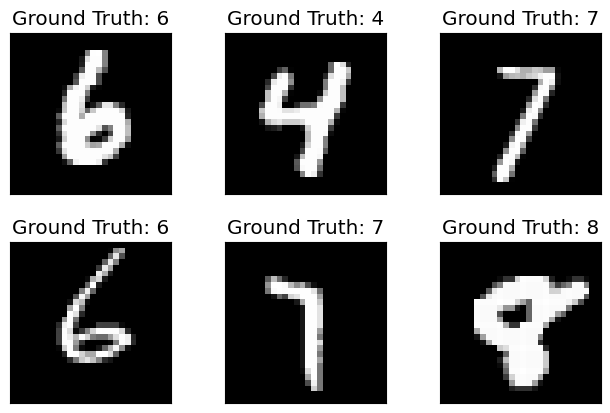

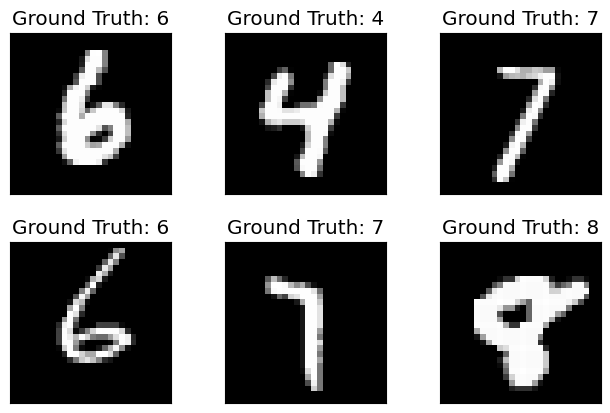

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  #convert back to orig shape
  original_shape = (28, 28)
  numpy_array = example_data[i]
  numpy_array = numpy_array.reshape(original_shape)

  plt.imshow(numpy_array, cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

As we can see, our train dataset loader appears to be working fine. To summarize, we first downloaded the data, converted it to tensors, normalized the data, shuffled and split the data into minibatches, finally exposed the data through dataloader.

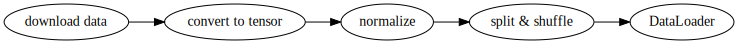

In [ ]:
#hide
gv('''
"download data"->"convert to tensor"->"normalize"->"split & shuffle"->"DataLoader"
''')

Instead of doing all the steps individually, wouldn't it be easy if we did this all in one go? There is a simplified way for doing just that using Pytorch!

### Simplified Code for DataLoader

In [8]:
# Define a custom transform function to flatten the tensor
def flatten_transform(data):
    # Assuming 'data' is a PyTorch tensor of size [batch_size, 28, 28]
    # batch_size, height, width = data.size()
    return data.view(-1)

In [9]:
batch_size_train = 64
batch_size_test = 64
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               flatten_transform
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               flatten_transform
                             ])),
  batch_size=batch_size_test, shuffle=True)

How simple is that!
- We have downloaded the data using `download=True`,
- converted the images to tensor and normalized it using known harded coded values for mean(0.1307) and std(0.3081) for MNIST train dataset.
- shuffled using `shuffle=True` parameter
- mini-batched using `batch_size` parameter

Using the `train=True/False` parameter, we have created a dataloader for the test loader as well. Note that, the test loader is using the same mean and std values as we did for train. This is because, any datapreprocessing we apply for train should be applied "as-is" for test as well. Moreover, peeping the test data to calculate mean and std is still cheating under the ML rule book.

Lets make sure our new dataloader using Pytorch is returning the corret shapes.

In [ ]:
example_data, example_targets = first(train_loader)

print('example_data.shape: {}'.format(example_data.shape))
print('len(example_targets): {}'.format(len(example_targets)))
example_data[0].shape

example_data.shape: torch.Size([64, 784])
len(example_targets): 64


torch.Size([784])

Lets check this for test loader as well.

In [ ]:
example_data, example_targets = first(test_loader)

print('example_data.shape: {}'.format(example_data.shape))
print('len(example_targets): {}'.format(len(example_targets)))
example_data[0].shape

example_data.shape: torch.Size([64, 784])
len(example_targets): 64


torch.Size([784])

We are good to proceed further!

## Model Architecture

### Neural Network
Lets create a neural network model from scratch. We will start with a simple single layer neural network with the number of inputs to be same size as the pixels we have and the output layer to have 10 outputs. Neural network equation is $$y=wx+b$$.

**Input & Output:** Before we design our neural network, we have to think about our input and output. Lets take one input and one output. Our input x is an image which has 784 pixels (28x28). i.e., we have 784 numbers for x, output. Our output is a prediction for one of the 10 classes. Therefore, y has to have 10 outputs.

![png](neural_network_rep.png)

**Weights & Biases:** Next we have to think about the shape of weights & bias as well. For this, we will work our way in reverse. We know we need 10 outputs. Bias is a number that gets added to wx to generate 10 outputs. Thus we know we need 10 numbers for bias. For calculating the shape of the weights, we made things simple by flattening our input image which now has 784 numbers for pixel values. Thus the weights should match the input size which is 784. Note the product of weights & input (wx) gets added to bias,  so the weights should also match the shape of bias. Thus weights should be a dimensional matrix of shape (input size, num_classes).

![png](neural_network_multiplication.png)

We can apply the same logic for batch processing and we will get the same results for the entire batch.

![png](neural_network_multiplication_batch.png)

Now that we have taken care of the math, first, we want to create a function for initializing the parameters.
Lets assume a basic single layer neural network.

In [ ]:
def init_params(size, std=1.0, requires_grad = True):
    """
    Initialize model parameters with random values.

    Args:
    - size (tuple): The size or shape of the parameter tensor.
    - std (float): The standard deviation of the random values (default is 1.0).

    Returns:
    - params (tensor): A tensor containing randomly initialized values for model parameters.
    """
    # Generate random values from a normal distribution with mean 0 and standard deviation 'std'.
    random_values = torch.randn(size) * std

    # Mark the tensor to require gradients, indicating that it's a learnable parameter.
    if requires_grad:
      params = random_values.requires_grad_()
    else:
      params = random_values

    return params

In [ ]:
weights = init_params((28*28,10))
weights.shape

torch.Size([784, 10])

We will set the bias to have 10 outputs. y=wx represents only a linear relationship. Adding bias b increases the flexibility of the model to travel anywhere along the y-axis.

**Why need bias?**
The bias term represents an offset or an intercept in the model. It allows the model to capture a baseline or an average value that is independent of the input features. Without the bias, the model would always pass through the origin (0,0) and could only represent relationships that go through the origin. Including a bias term increases the flexibility of the model. Without it, the model's hypothesis space is constrained to linear relationships passing through the origin, which might not be suitable for capturing complex patterns in the data.



In [ ]:
bias = init_params(10)
bias.shape

torch.Size([10])

In [ ]:
xb,yb = next(iter(train_loader))
xb.shape,yb.shape


(torch.Size([64, 784]), torch.Size([64]))

Lets try calculating the prediction for one image.

In [ ]:
(xb[0]@weights).shape # "@" symbol for matrix multiplication

torch.Size([10])

In [ ]:
pred = (xb[0] @ weights) + bias #y = wx + b
pred

tensor([ 24.3919, -51.7686,  13.9901, -22.6144,  47.2925,   4.1529, -24.6324, -37.5008,  47.0262,  35.0089], grad_fn=<AddBackward0>)

We seem to get some predictions numbers. If our task was a binary classification task, we can easily assume any positive number as positive classification and vice versa.

However, since this is a multi-label classification task, where each sample may belong to multiple classes, the prediction with the highest value is the class our simple linear model has classified the image as.

Lets get the argument (position) of the highest prediction value.

In [ ]:
# Get the index of the maximum value
max_index = pred.argmax()
print("predicted output:{}".format(max_index))
print("actual output:{}".format(yb[0]))

predicted output:4
actual output:4


Note: At this point, we are only getting the position of the max prediction value. The model does not know if it is predicting a 7 or a 3 or anything else. All the model is doing is giving its calculations for the 10 output positions.

Then you might ask, How can we tell what the model is predicting. This comes up only in the next step when we calculate Loss=(Prediction-Target). Only when the loss value is backpropagated, the model will know it tried to predict a highest value for position 3 however, the target value shows highest result for position 7. Thus by lining up the 10 predicted numbers with the 10 output targets, the model would know it needs to adjust its numbers to render a highest score on position 7.

### Softmax function

In the above example, you might ask, we already know the model's prediction. Isn't it enough to compare with the right answer and train whether the model is right or wrong? Can't we simply ignore the rest of the 9 numbers? No, we should not. Because, the model needs to learn from the incorrect answers as well.

But, we have a problem. The numbers seem to be over a wide range. The above example has a highest value of 45.2565 and lowest value of -23.6937. This is just for one image. Imagine doing this for multiple images and we will end up with multiple range of numbers. How can we make meaningful interpretation from these numbers? We need a common numbering system for the model's output. (Hint: Normalization)

This is where the SoftMax Function comes in handy. The softmax function grabs a vector of arbitrary real numbers and turn it into probabilities.

[!png](softmax_function.webp)

In summary,
1.  First, the model looks at each picture and measures how confident it is that a specific digit is in the picture. For example, if the machine sees a picture that looks a lot like the number 3, it will give it a high score for being the digit 3. If it's not sure, it might give it a lower score.

2. Next, the Softmax Function takes all these scores and turns them into probabilities. It ensures that the sum of all the scores equals 100% (or 1 in decimal form). So, the digit with the highest score gets the highest probability, and the one with the lowest score gets the lowest probability.



### Normalization vs Softmax
You might ask isn't Softmax same as Normalization? No, they are different.

1. **Normalization**:
   - Normalization refers to scaling data to have zero mean and unit variance or scaling it to a specific range (e.g., [0, 1]). It is used for data preprocessing and feature scaling.
   - Normalization doesn't change the fundamental characteristics of the data. It helps improve training convergence, especially for algorithms like gradient descent, by ensuring that features are on a similar scale.
   - It doesn't determine probabilities or make decisions; it's about feature scaling and numerical stability.

2. **Softmax Function**:
   - The softmax function is a specific activation function used in the output layer of a neural network for multi-class classification tasks.
   - It takes a vector of real numbers and converts them into a probability distribution over multiple classes. It assigns probabilities to each class, ensuring that they sum up to 1.
   - The softmax function is crucial for determining class probabilities and making decisions in classification problems. It's used to model the likelihood of each class given the network's input.
   - Softmax is used to map the model's raw scores (logits) into class probabilities, allowing you to choose the class with the highest probability as the predicted class.

### SoftMax Implementation

The softmax formula transforms the prediction output in a way that makes the biggest number the most likely choice, the next biggest number the second most likely choice, and so on.

$$  \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $$

In simple terms, softmax formula takes the "evidence" or "confidence" in each category $$x_i$$, amplifies it using exponentiation $$\exp(x_i)$$, and then calculates the probability of the input with respect to rest of the evidences across all categories $$\frac{1}{\sum_j \exp(x_j)}$$.

For implementation, we have to think numerical stability. In the softmax function, we need to exponentiate the elements of a vector. The problem arises when you need to compute the exponential of a large or small number, it can result in numerical overflow or underflow. This causes the output of Softmax to end up with `nan` outputs.

So to implement the softmax formula, we have to use the max subtraction of the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/). Given a set of values $$(x_1, x_2, x_3, \ldots, x_n)$$, we would find the maximum value, $$(M = \max(x_1, x_2, x_3, \ldots, x_n))$$, and then compute the exponentials as follows:

   $$
   \text{exp}(x_1, x_2, x_3, \ldots, x_n) = e^{x_1 - M} + e^{x_2 - M} + e^{x_3 - M} + \ldots + e^{x_n - M}
   $$

   The subtraction of \(M\) helps prevent overflow,

In [ ]:
def softmax(x):
    """
      Compute softmax scores given the raw output from the model
        :param scores: raw scores from the model (N, num_classes)
        :return:
            prob: softmax probabilities (N, num_classes)
      """
    #check dim
    if (len(x.shape)==2):
      # Exponentiate each element of the input along dim=1
      exp_x = torch.exp(x - x.max(dim=1, keepdim=True).values)
      # Calculate the sum of exponentiated values along dim=1
      sum_exp_x = torch.sum(exp_x, dim=1, keepdim=True)
    else:
      exp_x = torch.exp(x)
      sum_exp_x = torch.sum(exp_x)



    # Calculate the softmax probabilities for each element along dim=1
    softmax_probs = exp_x / sum_exp_x

    return softmax_probs

Lets try this sofmax function out. We expect the sum of the outputs to add up to 1.0 (100% probability).

In [ ]:
prob = softmax(pred)
print("prob.sum():{}".format(prob.sum()))
prob.shape

prob.sum():1.0


torch.Size([10])

Note that unlike normalization where we would have 0 mean and 1 standard deviation, the softmax doesnt affect the mean or standard deviation. However, it affects the sum of probabilities totalling to 1.0.

We have now converted the output of the predictions into probabilities across the output classes. Lets quickly check if our result is the same as we saw earlier with plain predictions.

In [ ]:
# Get the index of the maximum value
max_index = prob.argmax()
print("predicted output:{}".format(max_index))
print("actual output:{}".format(yb[0]))

predicted output:4
actual output:4


Now that we have the individual components, we can put them together into a model.

In [ ]:
def simple_net(xb):
  pred = xb @ weights + bias
  prob = softmax(pred)
  return prob

## Loss Function

Now that we have the predicted probabilities for the MNIST digits 0-9, we want to determine the losses so we can feed it back to alter the weights during back propagation.

As mentioned earlier, we dont want to pick the maximum probability and discard the remaining outputs as the wrong answers too are helpful for the model to learn. Example: if a model says, it is 50% confident an image is a 6, but the actual output is 9, we want to train the model so the confidence for 6 goes down. Ideally, the model should say 0% probability for 6 (and every other number), except for 9 which should have 100% probability.

Since we have decided to retain all the output answers, the next question is how do we extract the loss for each classification output? The **Cross Entropy Loss Function** comes to our rescue.

### Cross-entropy loss
- The categorical cross-entropy loss is exclusively used in multi-class classification tasks, where each sample belongs exactly to one of the N classes.
- Cross-entropy loss measures the difference between predicted probabilities and true labels.
- It heavily penalizes confident incorrect predictions.
- By minimizing this loss, the model learns to make more accurate predictions, which is the essence of classification in machine learning.
- The true label can be represented by an one-hot encoded vector of size N, which has the value one for the correct class and zero everywhere else, see example below for N = 4:

$$\text{label}_{4}= 2\rightarrow y = \begin{pmatrix}
     0\\
     0\\
     1\\
     0\\
 \end{pmatrix} $$


### Cross-entropy formula

The formula for categorical cross-entropy loss (also known as softmax loss or log loss) is calculated as:
$$ \text{Categorical Cross-Entropy Loss} = -\sum_{i}^{N} y_i \cdot \log(p_i)$$

Let's break down the formula for Categorical Cross-Entropy Loss step by step to understand it better.

1. **\(\sum_{i}\)**: This symbol stands for summation, which means we are summing over all the classes. In a multi-class classification problem, there can be many classes (e.g., classes for digits 0-9 in MNIST), and \(i\) represents each class.

2. **\(y_i\)**: \(y_i\) is the true probability (or one-hot encoded label) for class \(i\). In one-hot encoding, it's a binary value that is 1 for the true class and 0 for all other classes. For example, if you're classifying digits and the true class is 3, \(y_i\) would be 1 for \(i = 3\) and 0 for all other \(i\).

3. **\(p_i\)**: \(p_i\) is the predicted probability for class \(i\) given by your model. This is the probability that the model assigns to the input example belonging to class \(i\).

4. **\(-\log(p_i)\)**:
- When \(y_i = 1\), it means that the true label for the example corresponds to class \(i\). In other words, the true class is class \(i\).
- When the model assigns a high probability (\(p_i\)) to the true class (class \(i\)), the loss for that class becomes low because \(-\log(1) = 0\).
- However, when the model assigns a low probability to the true class, the loss for that class becomes high because \(-\log(p_i)\) is a positive value for \(p_i < 1\). The more the predicted probability deviates from 1 (i.e., it's lower than expected), the higher the loss.


5. **\(-\sum_{i} y_i \cdot \log(p_i)\)**: Finally, we sum up these \(-\log(p_i)\) terms over all classes. This summation measures the overall dissimilarity between the predicted probability distribution (\(p_i\)) and the true probability distribution (\(y_i\)).

The Categorical Cross-Entropy Loss quantifies how well the predicted probabilities match the true probabilities (one-hot encoded labels) for a multi-class classification problem. It encourages the model to increase the predicted probability for the true class while reducing the predicted probabilities for other classes. Minimizing this loss during training helps the model make better class predictions.

### Cross-Entropy Loss Implementation

In [ ]:
def cross_entropy_loss(y_true, y_pred, num_classes = 10):
    """
    Compute the Categorical Cross-Entropy Loss for a single example.

    Args:
    - y_true: True label for classes.
    - y_pred: Predicted probability distribution for classes.

    Returns:
    - loss: Categorical Cross-Entropy Loss for the example.
    """
    # Convert y_true label to one hot encoded label
    onehot_y = torch.eye(num_classes)[y_true]

    # Ensure that onehot_y and y_pred have the same shape
    assert onehot_y.shape == y_pred.shape, "Shapes of y_true and y_pred must match."

    # Compute the loss using the formula
    # Apply the log-sum-exp trick to the computation of the logarithm
    # This helps in preventing overflow or underflow when dealing with large or small probabilities
    loss = -torch.sum(onehot_y * torch.log(torch.clamp(y_pred, 1e-10, 1.0)))

    return loss

NOTE: Some of the probablities in y_pred are extremely tiny. Such tiny values are almost close to 0. Trying to do a log() of 0 is inf. This leads to underflow(nans) and overflows(inf). So we clamp the y_preds and consider only a predefined range.

Lets test out the cross entropy loss.

In [ ]:
cross_entropy_loss(yb[0], prob)

tensor(0.5688, grad_fn=<NegBackward0>)

Lets try out some toy examples. Suppose the predicted probability is (0.8, 0.1,0.1) is close to the true probability is (1,0,0). We expect the loss to be cross entropy loss to be low.

In [ ]:
y_true = 0
y_pred = torch.tensor([0.8,0.2,0.2])
cross_entropy_loss(y_true, y_pred, num_classes=3)

tensor(0.2231)

On the contrary, if predicted probability(0.2, 0.6,0.2) is far off from the true probability is (1,0,0). We expect the loss to be cross entropy loss to be higher.

In [ ]:
y_true = 0
y_pred = torch.tensor([0.2,0.6,0.2])
cross_entropy_loss(y_true, y_pred, num_classes=3)

tensor(1.6094)

So we have proved our loss function is working as expected.

So far, this is how our model architecture is looking after adding softmax and cross entropy layers.

![png](model_architecture.png)

## Gradient Descent - Manual Calculation

Now that we have the forward pass with activation, lets calculate the backward pass to determine gradients.

Similar to my [gradient descent article]({% post_url 2023-09-14-Gradient_Descent_Basics %}), we will follow the below steps to determine gradients and update our parameters.

1. run model & get predictions
2. calc loss from predictions & true labels
3. calculate gradients
4. update gradients

In terms of Pseudocode, we get:
```python
for x,y in dl:
    pred = model(x) #run model & get predictions
    loss = loss_func(pred, y) #calc loss from predictions & true labels
    loss.backward() #calculate gradients
    parameters -= parameters.grad * lr #update gradients
```

![png](gradient_descent.png)

### Run Model & Calc Loss

We will first reinitialize our parameters.

In [ ]:
weights = init_params((28*28,10), requires_grad = False) #note: we have turned off requires grad
bias = init_params(10, requires_grad = False) #note: we have turned off requires grad
weights.shape,  bias.shape

(torch.Size([784, 10]), torch.Size([10]))

We will create a mini-batch of size 4 for testing:



In [ ]:
batch = example_data[:4]
batch.shape

torch.Size([4, 784])

We will run this simple minibatch sample through our model and get predictions. Since predictions are probabilities (across 10 output layers) from the softmax layer, we expect the sum of all predictions to equate to 1.0 (100% probability).

In [ ]:
preds = simple_net(batch)
print("preds.shape:{}".format(preds.shape))
for i in preds:
  with torch.no_grad():
    print("simple_net -  preds:{}".format(i))
    print("simple_net -  sum of preds:{}".format(i.sum())) #sum of preds should be 1.0

preds.shape:torch.Size([4, 10])
simple_net -  preds:tensor([6.5931e-01, 1.0749e-29, 2.3680e-19, 5.9656e-41, 1.0338e-38, 1.2225e-03, 3.3947e-01, 3.7747e-12, 1.2969e-30, 2.8681e-08])
simple_net -  sum of preds:1.0
simple_net -  preds:tensor([8.2832e-09, 2.0217e-19, 2.5385e-23, 1.1825e-23, 1.8589e-10, 4.6610e-17, 4.9582e-01, 3.5712e-23, 5.0418e-01, 2.5376e-24])
simple_net -  sum of preds:1.0
simple_net -  preds:tensor([7.6778e-01, 3.7658e-03, 1.7342e-10, 4.6965e-13, 2.7946e-34, 7.2466e-12, 2.2846e-01, 2.2359e-07, 7.2267e-22, 4.2496e-19])
simple_net -  sum of preds:1.0000001192092896
simple_net -  preds:tensor([1.0000e+00, 1.9510e-28, 2.9353e-10, 1.1456e-20, 5.0176e-28, 8.8912e-07, 6.2503e-19, 1.9154e-26, 2.3416e-30, 4.6136e-22])
simple_net -  sum of preds:1.0


Looking at the results, we have 4 rows of 10 probabilities for with the model's prediction in terms of probability for each of the 10 classes. Note with the help of Pytorch's broadcasting, we dont have to reshape the simple_net model.

Next, we will calculate the cross entrophy loss to see how well our model is performing with respect to the true classes.

In [ ]:
loss = cross_entropy_loss(example_targets[0:4], preds)
loss

tensor(92.1034)

### Calculate Gradients
- Calculus helps us to calculate whether our loss will go up or down when we adjust our parameters up or down.
- From Calculus basics, derivative of a function tells us how much change in its parameters will change its result.

Before we can calcuate the derivative of a function, we need to represent our model using a **computation graph**. Computation graph is a visual representation of mathematical operations and their dependencies. It helps us describe the flow of data and operations in a mathematical model. Computation graph will help us calculate the gradients.

**Computation Graph:**

![png](computation_graph.png)

As we can see computation graph is similar to the model architecture but tries to detail out every mathematical function.

**Calculate Derivatives:**

Now that we have the computation graph, our intent is to calculate the derivative of the Loss with respect to the parameters (weights & biases). i.e., $$\frac{dL}{dW}$$ & $$\frac{dL}{db}$$. Calculating these values in one go will be an extremely difficult thing to do. This is why computation graph is helpful: we can walk back from loss and calculate the gradient at each mathematical operation.

![png](computation_graph_derivative.png)

As shown in the image below, we can start from the end. We have the loss value result.
- Using the loss value result, and knowing the derivative of the cross-entropy loss & Softmax function, we calculate $$dL/dz$$ as follows:
$$dL/dz = s-y$$
- With the result of $$dL/dz$$, we can calculate the derivative of the loss with respect to bias $$dz/db = 1$$ and weights $$dz/db = x$$.
- Finally with calculus's chain rule, we can calculate the gradients by putting together the above:
$$\frac{dL}{dW} = \frac{dL}{dz}.\frac{dz}{dW} $$.
Similarly,
$$\frac{dL}{db} = \frac{dL}{ds}.\frac{ds}{dz}.\frac{dz}{db} $$
Once we know the gradients of Loss with respect to the parameters: bias and weights, we can update the parameters with these calculated gradients in order to reduce the loss during the next epoch. You might ask how we arrived at these equations:

NOTE: We treat the softmax & cross entropy as one layer and calculate the gradients for this combined unit. This is for numerical stability as the softmax & log operations involved in cross-entropy can produce extremely small or large numbers, which may result in numeric overflow or underflow. This is why we avoid calculating dL/ds and rather directly calculate dL/dz
[This article](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) is an excellent resource that dives into the mathematical details of how the gradients are calculated for softmax and cross entropy layer.




**Code Implementation:**

Implementing this is easier said than done. One thing to remember is the size of the gradients would match the size of the actual activations. For instance, if the output of softmax is of shape 64x10, then the derivative at the end of softmax should also be 64x10. (A gradient value for every input). As long as we follow, the same shape when deriving derivatives, we are in safe place.

We will start with initializing variables for holding the gradients for weights and bias.

In [ ]:
def init_grads(size):
    """
    Initialize model gradients with zero values.

    Args:
    - size (tuple): The size or shape of the parameter tensor.

    Returns:
    - params (tensor): A tensor containing randomly initialized values for model parameters.
    """
    # Generate zeros of required size
    grads = torch.zeros(size)

    return grads

In [ ]:
grad_weights = init_grads((28*28,10))
grad_bias = init_grads(10)
print("grad_weights.shape:{}".format(grad_weights.shape))
print("grad_bias.shape:{}".format(grad_bias.shape))

grad_weights.shape:torch.Size([784, 10])
grad_bias.shape:torch.Size([10])


In [ ]:
def manual_backward(s, y, batch):
  """
    Calculate model gradients. (similar to loss.backward in Pytorch but done manually)

    Args:
    - s (N,10): probability predictions from softmax layer
    - y (N): true labels

    Returns:
    - None
    """
  with torch.no_grad(): #we do not want to pytorch to calc gradients since we are manually doing it
    # =========== 1) calc b2 gradients ===========
    #step1: compute dL_ds where L = CE(softmax(Z),y)
    #get num of classes
    # print("s.shape:{}".format(s.shape))
    # print("y.shape:{}".format(y.shape))
    num_classes = s.shape[1]
    onehot_y = np.eye(num_classes)[y]  # onehot_y = 64 x 10
    # print("num_classes:{}".format(num_classes))
    # print("onehot_y.shape:{}".format(onehot_y.shape))
    # __step1b:subtract s - y (ensure shape of both are (N,10)
    # (64,10) (4,10)
    dL_dZ = s - onehot_y  # dL_dA = 64 x 10
    # print("s:{}".format(s))
    # print("onehot_y:{}".format(onehot_y))
    # print("dL_dZ:{}".format(dL_dZ))
    #step3: calc dL_db [10x1] = dL_dZ[64x10] * ones [64x1]
    dZ_db = np.ones((dL_dZ.shape[0],1))
    dL_db = np.dot(dL_dZ.T,dZ_db)
    #step3: update bias  - divide by batch size N - shape: (10,)
    grad_bias = (dL_db/batch.shape[0]).flatten()
    # =========== 2) calc W2 gradients ===========
    #step1: Compute dZ_dW = X [64x784]
    dZ_dW = np.copy(batch)
    #step2: find dL_dW = dL_dZ [64x10] * dZ_dW [64x784]
    dL_dW = np.dot(dL_dZ.T, dZ_dW).T # [784x10]
    # step3: update bias  - divide by batch size N - shape: (10,)
    grad_weights= (dL_dW / batch.shape[0])
  return torch.from_numpy(grad_weights), torch.from_numpy(grad_bias) #convert to torch before returning



Pytorch uses similar technique to calculate gradients. You can read more about it in this [Pytorch Article](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/).

In [ ]:
grad_weights, grad_bias = manual_backward(preds, example_targets[:4], example_data[:4])
#making sure the grad weights and grad bias are of proper shape
print("grad_weights.shape:{}".format(grad_weights.shape))
print("grad_bias.shape:{}".format(grad_bias.shape))

grad_weights.shape:torch.Size([784, 10])
grad_bias.shape:torch.Size([10])


Great! Now that we have the gradients for weights and bias, lets put it all into a function for easy calling.

In [ ]:
def calc_grad_manual(xb, yb, model):
    preds = model(xb)
    loss = cross_entropy_loss(yb, preds)
    grad_weights, grad_bias = manual_backward(preds, yb, xb)
    return grad_weights, grad_bias

Now lets test out the function using our small mini batch.

In [ ]:
grad_weights, grad_bias = calc_grad_manual(batch, example_targets[0:4], simple_net)
grad_weights.sum(),grad_bias.sum()

(tensor(-1.4336e-06, dtype=torch.float64),
 tensor(7.9055e-08, dtype=torch.float64))

### Update parameters

- The last step is to update the weights and biases based on the gradient and learning rate.

Lets write up a function to take the learning rate, params and model as input, cycle through the input, calculate gradients for the parameters and then finally update the parameters (and also reset it for the next cycle). All this is considered one epoch (aka iteration). For the next iteration, we repeat this process with updating parameters and even learning rate if we consider any decay.

In [ ]:
def train_epoch_manual(model, lr, weights,bias):
    for xb,yb in train_loader:
        with torch.no_grad():
          grad_weights, grad_bias = calc_grad_manual(xb, yb, model)
          weights -= grad_weights*lr  #update weights
          bias -= grad_bias*lr #update weights
          #no need to resets gradients to zero as they are calc from scratch
    return weights,bias #return updated weights and bias so they can be fed as input during next itration

## Validation

During the validation phase, we do not train (update parameters) our model any more. We will evaluate the model to see how well it is doing. Remember, we have validation data as well from MNIST. We will evaluate our model with the validation data. The model will use its trained parameters which are frozen during this validation phase.

### Compute Accuracy

Although we have loss, it is only used to calculate the gradients. We need a metric for us, humans to decide how good our model is doing with respect to the original task - classifying MNIST images as numbers. We can use a simple accuracy metric - determine how many correct predictions among all the predictions.

In [17]:
 def compute_accuracy(x_pred, y):
  """
  Compute the accuracy of current batch
  :param x_pred: Probabilities from the model (N, num_classes)
  :param y: Labels of instances in the batch
  :return: The accuracy of the batch
  """
  acc = None
  predictions = torch.argmax(x_pred, axis=1)
  acc = torch.sum(torch.eq(y, predictions)) / len(predictions)
  return acc


We can quickly check our metric function with our earlier 4 sample images minibatch.

In [ ]:
compute_accuracy(preds, example_targets[0:4])

tensor(0.)

### Validation Function

For the validation function, we want to run the validation data through our trained model, get those predictions and compute the accuracy metric to decide how well our model is doing. We can write a function for that:

In [15]:
def validate_epoch(model):
    accs = [compute_accuracy(model(xb), yb) for xb,yb in test_loader] #notice how we have used "test_loader" to load validation data instead of train loader
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(simple_net)

0.0785

This accuracy is our starting point with random values for weights and biases. (we havent trained our model yet). In the next section, we will train our model and repeat validation to see how well our model is doing.

## Training

The parameters `weights` & `bias` are already setup with `requires_grad_()` so, Pytorch will automatically continue calculating gradients for us. Let's train for one epoch, and see if the accuracy improves. One Epoch here means one iteration through the entire MNIST dataset. So this means cycle through all mini batches of train dataset during the train phase and cycle through all mini batches of test dataset during the test phase.

In [ ]:
lr = 1.
train_epoch_manual(simple_net, lr, weights,bias)
validate_epoch(simple_net)

0.8776

Our accuracy has improved just after one epoch! Now, lets try training for 20 epochs.

In [ ]:
for i in range(20):
    weights,bias = train_epoch_manual(simple_net, lr, weights,bias)
    print(validate_epoch(simple_net), end=' ')

0.865 0.7881 0.8779 0.8127 0.852 0.8088 0.8378 0.8521 0.8225 0.865 0.8977 0.8944 0.8738 0.8402 0.886 0.8197 0.8669 0.9133 0.8083 0.7729 

Excellent! Our training seems to train our model, increasing its accuracy during each epoch. In the next section, lets do the same thing but using Pytorch's auto grad function.

## Gradient Descent - Using Pytorch

Before we attempt gradient descent using Pytorch, we will initialize the weights and bias, setup a small batch, run it through our linear model and calculate loss. Unlike last time using manual approach, this time we want Pytorch to calculate the gradients for us. The default value is True so when we call init_params(), our function defaults to require grads.

In [ ]:
#initialize weights and bias
weights = init_params((28*28,10))
bias = init_params(10)
#setup batch
batch = example_data[:4]
#predictions
preds = simple_net(batch)
#calc loss
loss = cross_entropy_loss(example_targets[0:4], preds)

PyTorch is known for its **automatic differentiation capability**, which allows it to compute derivatives of functions with respect to their inputs. This automatic differentiation feature is incredibly powerful for deep learning because it allows you to define complex neural network architectures and loss functions while PyTorch handles the tedious task of calculating gradients.

Now we can calculate the gradients using Pytorch which hugely simplifies things. i.e., we do not need the `manual_backward()` from the previous section since Pytorch does it for us. Here is a quick check.

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean()

(torch.Size([784, 10]), tensor(2.4328e-10))

It still surprises me how this one line of code calculates the entire gradients for weights and biases

Lets put the entire logic into a function. We get:

In [11]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = cross_entropy_loss(yb, preds)
    loss.backward() #calc gradients

We can also make sure this function is working fine with our micro minibatch with 4 samples.

In [ ]:
calc_grad(batch, example_targets[0:4], simple_net)
weights.grad.sum(),bias.grad.sum()

(tensor(3.8147e-06), tensor(0.))

NOTE: `loss.backward` actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first.

If we do not reset the gradients and try to calculate gradients, those calculated gradients will be added to current gradients. So when updating parameters, it would lead to incorrect updates.

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

### Update parameters

- The last step is to update the weights and biases based on the gradient and learning rate.
- When updating the parameters, we have to tell Pytorch to not consider this piece of updating parameters when calculating gradients on the next iteration.
- If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step.

Lets write up a function to take the learning rate, params and model as input, cycle through the input, calculate gradients for the parameters and then finally update the parameters (and also reset it for the next cycle). All this is considered one epoch (aka iteration). For the next iteration, we repeat this process with updating parameters and even learning rate if we consider any decay.

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in train_loader:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr #p.data tells Pytorch to exclude this step during gradient calculation
            p.grad.zero_() #resets gradients to zeros

### Training

We can now run the training for 20 epochs and see how it does on the validation data at the end of each epoch. Note how we do not need to pass in or pass out parameters like we did in the manual way as Pytorch does it for us.



In [ ]:
lr = 1.
params = weights, bias
for i in range(20):
    train_epoch(simple_net, lr, params)
    print(validate_epoch(simple_net), end=' ')

0.3074 0.3084 0.3077 0.3092 0.3059 0.3057 0.3091 0.3093 0.3091 0.3076 0.3047 0.3066 0.3077 0.3096 0.3089 0.3088 0.3094 0.3095 0.3091 0.3113 

## Optimizing using Pytorch

In this section we will create an Optimizer to optimize the code using Pytorch! (see how I played with words there! :))
Well, 'Optimizer' is a Pytorch object that will handle the SGD step for us. We will create a super simple basic optimizer which wil help us to understand how things work in Pytorch. In order to create the Pytorch Optimizer, we first need to rewrite our model using Pytorch.


### Model in Pytorch

Earlier we had used `simple_net()` function to create our model. This model too can be defined in Pytorch which will hugely simplify things for us and help us build more complex models just by describing them and not having to worry about the implementation (as Pytorch will take care of it).

In [36]:
# Define your linear model
linear_model = nn.Linear(28 * 28, 10)

# Create a model that includes the linear layer and softmax layer
simple_net_pytorch = nn.Sequential(
    linear_model,
    nn.Softmax(dim=1)
)

We first define the linear model using nn.Linear. Then, we create a new model called `simple_net_pytorch` using nn.Sequential, which combines the linear layer with a softmax layer. When you pass input data to `simple_net_pytorch`, it will apply the linear transformation and then the softmax activation to produce output probabilities.

In [ ]:
w,b = simple_net_pytorch.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

Excellent! The shape of our parameters shows that this is exactly the same shape of the parameters used with our manual parameter initialization. Also, notice how we only defined our model while Pytorch took care of the parameters shape and initialization for us. Now that we have the model in Pytorch, the next step is to create a Basic Optimizer.

### Optimizer in Pytorch

Below we define a basic optimizer class called BasicOptim. This class is a simple implementation of an optimizer for updating model parameters during training. It has two main methods, step and zero_grad, which are commonly found in optimizers. The BasicOptim takes two arguments: `params` and `lr`. `params` is a list of model parameters that need to be optimized, and `lr` is the learning rate for the optimizer.



In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can already see the how this Basic Optimizer can be used to replace the parameter update step and reset grad steps in the `train_epoch()` we defined earlier.

Note that PyTorch provide built-in optimizers (e.g., torch.optim.SGD, torch.optim.Adam) that are highly optimized and often come with additional features, like support for various optimization algorithms, learning rate schedules, and weight decay.



 We can now initialize the Basic optimizer so that it will update the parameters of your simple_net_pytorch model with the specified learning rate during training.

In [ ]:
opt = BasicOptim(simple_net_pytorch.parameters(), lr)

### Training with Optimizer

Now that we have our optimizer, our `train_epoch()` can be updated as below.

In [ ]:
def train_epoch(model):
    for xb,yb in train_loader:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Note there is no change to our validation function. We can simply pass in the new model name `simple_net_pytorch`. Lets check out how our untrained parameters performa with the validation data.

In [ ]:
validate_epoch(simple_net_pytorch)

0.0883

We can put all this code together in a function called `train_model()` that trains a model for a specified number of epochs and prints validation results after each epoch.

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(simple_net_pytorch, 20)

0.6968 0.7202 0.7344 0.7285 0.7373 0.7441 0.7267 0.7443 0.7383 0.7501 0.7471 0.7525 0.7522 0.7486 0.7462 0.739 0.7401 0.7495 0.7489 0.747 

Excellent, our model seems to training well with our Pytorch simple net model, and Basic Optimizer code. Next, we will replace our Basic Optimizer with Pytorch's built in SGD optimizer.

### Using Pytorch's SGD Optimizer

The initialization of the SGD Optimizer is same as Basic Optimizer.  This optimizer takes care of updating the model's parameters and applying the SGD optimization algorithm.

This approach is recommended because PyTorch's built-in optimizers are well-tested and optimized, and they provide various options for fine-tuning your optimization process, such as momentum, weight decay, and learning rate schedules.

In [ ]:
# Create the SGD optimizer
optSGD = torch.optim.SGD(simple_net_pytorch.parameters(), lr=lr)

We will create a new train_epoch() with the SGD Optim. We are only changing the variable name. The method names as same.

In [ ]:
def train_epochSGD(model):
    for xb,yb in train_loader:
        calc_grad(xb, yb, model)
        optSGD.step()
        optSGD.zero_grad()

We will also update the train model function to refer to the SGD train_epoch().

In [ ]:
def train_modelSGD(model, epochs):
    for i in range(epochs):
        train_epochSGD(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_modelSGD(simple_net_pytorch, 20)

0.5626 0.5652 0.5647 0.5704 0.571 0.572 0.5754 0.5736 0.5697 0.5753 0.5764 0.5705 0.5782 0.5765 0.5769 0.5728 0.5767 0.5803 0.5761 0.5772 

## Increasing Model Complexity

So far we have used a super simple model with one linear input layer and Softmax layer for class probabilities. This model is limited in what it can learn. You can see from the previous step that the accuracy of this training gets topped off at 60 to 70\%.

### Why Linear Models are Constrained?
- Linear classifiers are simple models that can only separate data using linear decision boundaries.
- They are suitable for relatively simple classification tasks where the underlying patterns in the data can be captured by straight lines or hyperplanes.
- However, many real-world problems require more complex models to capture non-linear relationships in the data. Here


### How do we increase Model Complexity?
We can create a more complex model such as a deep neural networks with non-linear activation functions like ReLU, sigmoid, or tanh between linear networks. These Deep learning models can capture intricate patterns in the data.



### Non-Linear Activation Function: ReLU

- "ReLU" stands for "Rectified Linear Unit."
- The ReLU activation function is defined as:

$$ f(x) = max(0, x) $$

- In this formula, \(x\) represents the input to the activation function.
- If \(x\) is greater than or equal to zero, the ReLU function returns \(x\).
- If \(x\) is negative, it returns zero.
- This makes it a simple, piecewise linear function with a non-linearity introduced at \(x = 0\).
- The term "ReLU" is used to refer to this specific activation function because it rectifies (i.e., sets to zero) any negative values in the input.
- It is one of the most widely used activation functions in deep learning due to its simplicity and effectiveness.


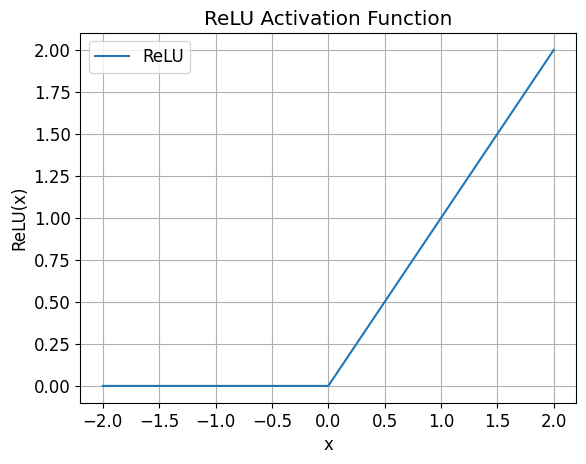

In [ ]:

# Define the range of x values
x = np.linspace(-2, 2, 400)

# Calculate the corresponding ReLU values
relu_values = [F.relu(torch.tensor(val)).numpy() for val in x]

# Create the plot
plt.plot(x, relu_values, label='ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU Activation Function')
plt.grid()
plt.legend()
plt.show()


### Two Layer Net

Lets define a neural network model called `two_layer_net` consists of two linear layers separated by a ReLU activation function and a Softmax activation function. It takes an input vector of size 28*28, applies a linear transformation followed by a ReLU activation, then applies another linear transformation, and finally, applies a Softmax activation to produce class probabilities.

In [3]:
# Create a model that includes two linear layers with a ReLU inbetween and softmax layer output
two_layer_net_pytorch = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 10),
    nn.Softmax(dim=1)
)

### Number of Model Parameters

The number of parameters between our simple_net and two_layer_net have gone up too. This also introduces complexity as the model now has to learn weights and biases for a more unknowns.

In our Simple Net model, we have two components:

1. `nn.Linear(28 * 28, 10)` - This is a linear layer that maps an input of size 28 * 28 to an output of size 10. It has a weight matrix of shape (10, 784) and a bias vector of shape (10). So, the number of parameters in this linear layer is:

   - Number of parameters in the weight matrix = 10 (output features) x 784 (input features) = 7,840.
   - Number of parameters in the bias vector = 10.

   Total parameters in this linear layer = 7,840 (weight matrix) + 10 (bias vector) = 7,850 parameters.

2. `nn.Softmax(dim=1)` - The softmax layer doesn't introduce any new parameters. It's simply a mathematical operation applied to the output of the linear layer.

In [111]:
w,b = simple_net_pytorch.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

Therefore, the total number of parameters in our `simple_net_pytorch` model is the number of parameters in the linear layer, which is 7,850 parameters.

The number of model parameters in our `two_layer_net_pytorch` model, Here's the breakdown:

1. **First Linear Layer:**
   - Input Features: 28 * 28 = 784
   - Output Features: 30
   - Number of Parameters (Weights and Biases): (784 input features * 30 output features) + 30 bias terms = 23,550 parameters

2. **Second Linear Layer:**
   - Input Features: 30
   - Output Features: 10
   - Number of Parameters (Weights and Biases): (30 input features * 10 output features) + 10 bias terms = 310 parameters

3. **Softmax Layer:**
   - The Softmax layer does not introduce any additional parameters. It's a normalization operation.

Now, we can sum up the parameters from each of the layers to get the total number of model parameters:

Total Parameters = 23,550 (First Linear Layer) + 310 (Second Linear Layer) = 23,860 parameters

In [112]:
w1,b1,w2,b2 = two_layer_net_pytorch.parameters()
w1.shape,b1.shape,w2.shape,b2.shape

(torch.Size([30, 784]),
 torch.Size([30]),
 torch.Size([10, 30]),
 torch.Size([10]))

So, our `two_layer_net_pytorch` model has a total of 23,860 parameters. These parameters are used to define the weights and biases that the model learns during training to make predictions. Increasing the number of parameters in a model typically increases its capacity to fit the training data.

## End-to-End Pytorch Code

### Setup DataLoaders

In [5]:
# Define a custom transform function to flatten the tensor
def flatten_transform(data):
    # Assuming 'data' is a PyTorch tensor of size [batch_size, 28, 28]
    # batch_size, height, width = data.size()
    return data.view(-1)


In [6]:
batch_size_train = 64
batch_size_test = 64
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               flatten_transform
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                               flatten_transform
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Setup Model

In [7]:
# Create a model that includes two linear layers with a ReLU inbetween and softmax layer output
two_layer_net_pytorch = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 10),
    nn.Softmax(dim=1)
)

### Setup Optimizer

In [8]:
# Create the SGD optimizer
lr= 0.001
optSGD = torch.optim.SGD(two_layer_net_pytorch.parameters(), lr=lr)

### Setup Loss Function

In [9]:
def cross_entropy_loss(y_true, y_pred, num_classes = 10):
    """
    Compute the Categorical Cross-Entropy Loss for a single example.

    Args:
    - y_true: True label for classes.
    - y_pred: Predicted probability distribution for classes.

    Returns:
    - loss: Categorical Cross-Entropy Loss for the example.
    """
    # Convert y_true label to one hot encoded label
    onehot_y = torch.eye(num_classes)[y_true]

    # Ensure that onehot_y and y_pred have the same shape
    assert onehot_y.shape == y_pred.shape, "Shapes of y_true and y_pred must match."

    # Compute the loss using the formula
    # Apply the log-sum-exp trick to the computation of the logarithm
    # This helps in preventing overflow or underflow when dealing with large or small probabilities
    loss = -torch.sum(onehot_y * torch.log(torch.clamp(y_pred, 1e-10, 1.0)))

    return loss

### Setup Validation Functions

In [10]:
 def compute_accuracy(x_pred, y):
  """
  Compute the accuracy of current batch
  :param x_pred: Probabilities from the model (N, num_classes)
  :param y: Labels of instances in the batch
  :return: The accuracy of the batch
  """
  acc = None
  predictions = torch.argmax(x_pred, axis=1)
  acc = torch.sum(torch.eq(y, predictions)) / len(predictions)
  return acc


In [11]:
def validate_epoch(model):
  accs = [compute_accuracy(model(xb), yb) for xb,yb in test_loader] #notice how we have used "test_loader" to load validation data instead of train loader
  return round(torch.stack(accs).mean().item(), 4)

### Setup Training Loops

In [12]:
running_loss_array = [] # for plotting

In [13]:
def train_modelSGD(model, epochs):
    for epoch in range(epochs):
      #reset running loss term at the start of each epoch
      running_loss = 0.0
      # Inside each training epoch
      for xb,yb in train_loader:
        # Forward pass: compute the predictions
        preds = model(xb)
        # Compute the loss
        loss = cross_entropy_loss(yb, preds)
        # Backpropagation: compute gradients
        loss.backward()
        # Update model parameters using the optimizer
        optSGD.step()
        # Zero out gradients for the next iteration
        optSGD.zero_grad()
        #update running loss
        running_loss += loss.item()
        # Validate model with test data
      print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
      running_loss_array.append(running_loss / len(train_loader))
    print("Training finished")

Note:  
Instead of our custom cross entropy function, you could also use Pytorch's builtin CrossEntropy() by replacing with this line `loss = nn.CrossEntropyLoss()(preds, yb)`. The loss numbers might be a bit different due to our clipping implementation. Otherwise it should work the same.

### Validate Untrained Model

In [14]:
validate_epoch(two_layer_net_pytorch)

0.1002

### Train Model

In [15]:
train_modelSGD(two_layer_net_pytorch, 40)

Epoch 1, Loss: 21.64170510809559
Epoch 2, Loss: 12.012829680940998
Epoch 3, Loss: 9.28272529616793
Epoch 4, Loss: 7.771995860503426
Epoch 5, Loss: 6.813918805198629
Epoch 6, Loss: 6.1480219960848155
Epoch 7, Loss: 5.5584299946898845
Epoch 8, Loss: 5.223822747244001
Epoch 9, Loss: 4.834864173711998
Epoch 10, Loss: 4.5417323889318055
Epoch 11, Loss: 4.348731679829961
Epoch 12, Loss: 4.027827564062975
Epoch 13, Loss: 3.8369525568222187
Epoch 14, Loss: 3.672533843833119
Epoch 15, Loss: 3.4955074800245924
Epoch 16, Loss: 3.364580295392191
Epoch 17, Loss: 3.1875008494297323
Epoch 18, Loss: 3.051080211345702
Epoch 19, Loss: 2.900613680180075
Epoch 20, Loss: 2.789949094840903
Epoch 21, Loss: 2.678583399398622
Epoch 22, Loss: 2.524789593232148
Epoch 23, Loss: 2.4927152235751975
Epoch 24, Loss: 2.3354366941095543
Epoch 25, Loss: 2.2465149307413013
Epoch 26, Loss: 2.196204055855269
Epoch 27, Loss: 2.1166796047232554
Epoch 28, Loss: 1.9974658906753702
Epoch 29, Loss: 1.8981787455377421
Epoch 30, L

### Plot Train Loss Curve

In [16]:
def plot_loss(loss_array, title="Loss Curve", xlabel="Epoch", ylabel="Loss"):
    """
    Plot a loss curve from an array of loss values.

    Args:
    - loss_array (list): List of loss values to be plotted.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(loss_array, label="Loss")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

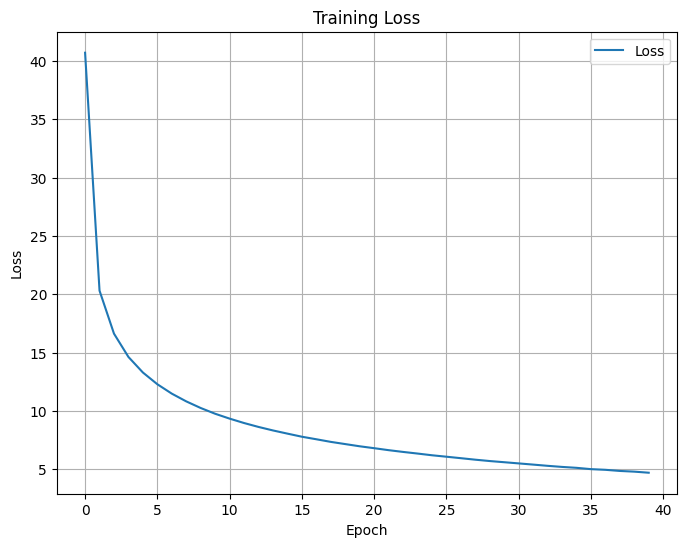

In [106]:
plot_loss(running_loss_array, title="Training Loss", xlabel="Epoch", ylabel="Loss")

### Validate Model

In [17]:
validate_epoch(two_layer_net_pytorch)

0.9674

Excellent! We have achieved a good accuracy on our trained model indicating our implementation is working well! We will run some more tests to see if the model is really working.

In [29]:
# Make predictions on the test data
predictions = []
true_labels = []

with torch.no_grad():
  outputs = two_layer_net_pytorch(example_data[5:10])
  # find the maximum value and its corresponding index along the second dimension - ignore the max value '_'
  _, predicted = torch.max(outputs, 1)
  predictions.extend(predicted)
  true_labels.extend(example_targets[5:10])

# Interpret the predictions
for i in range(len(predictions)):
    print(f"Prediction: {predictions[i]}, True Label: {true_labels[i]}")

Prediction: 4, True Label: 4
Prediction: 6, True Label: 6
Prediction: 4, True Label: 4
Prediction: 0, True Label: 0
Prediction: 7, True Label: 7


Thats the end of this article. You can access this notebook here. You can check out my other articles as I try to understand ML.

## Reference:
- https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb
- https://nextjournal.com/gkoehler/pytorch-mnist
- https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3
- https://jaykmody.com/blog/stable-softmax/